# Importar librerías + data

In [62]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers, models, utils, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [39]:
# Load data and change dtype
data = (
    pl.scan_parquet('datasets/teams/battlelog_train.parquet')
    ).collect()

data.columns

['winner',
 'barriers',
 'barriers_center',
 'bushes',
 'bushes_center',
 'waterProp',
 'event_mode',
 'event_map',
 'battle_player1_brawler_name',
 'battle_player2_brawler_name',
 'battle_player3_brawler_name',
 'battle_player1_brawler_Class',
 'battle_player2_brawler_Class',
 'battle_player3_brawler_Class',
 'battle_player1_brawler_Role',
 'battle_player2_brawler_Role',
 'battle_player3_brawler_Role',
 'battle_power',
 'avg_brawler_trophies',
 'brawler_trophies_min',
 'brawler_trophies_max',
 'avg_trophies',
 'trophies_min',
 'trophies_max',
 'avg_highestTrophies',
 'highestTrophies_min',
 'highestTrophies_max',
 'avg_brawler_Health',
 'brawler_Health_min',
 'brawler_Health_max',
 'avg_brawler_winrate',
 'brawler_winrate_min',
 'brawler_winrate_max',
 'avg_brawler_winrate_overall',
 'brawler_winrate_overall_min',
 'brawler_winrate_overall_max',
 'avg_brawler_userate',
 'brawler_userate_min',
 'brawler_userate_max',
 'avg_brawler_userate_overall',
 'brawler_userate_overall_min',
 'bra

In [40]:
# subset dataframe
data = data[[
	'winner'
    ,'barriers'
	,'barriers_center'
	,'bushes'
	,'bushes_center'
	,'waterProp'
	,'event_mode'
	,'event_map'
	,'battle_player1_brawler_name'
	,'battle_player2_brawler_name'
	,'battle_player3_brawler_name'
    ,'battle_player1_brawler_Class'
	,'battle_player2_brawler_Class'
	,'battle_player3_brawler_Class'
	,'battle_player1_brawler_Role'
	,'battle_player2_brawler_Role'
	,'battle_player3_brawler_Role'
	,'battle_power'
	,'avg_brawler_trophies'
	,'brawler_trophies_min'
	,'brawler_trophies_max'
	,'avg_trophies'
	,'trophies_min'
	,'trophies_max'
	,'avg_highestTrophies'
	,'highestTrophies_min'
	,'highestTrophies_max'
	,'avg_brawler_Health'
	,'brawler_Health_min'
	,'brawler_Health_max'
	,'avg_brawler_winrate'
	,'brawler_winrate_min'
	,'brawler_winrate_max'
	,'avg_brawler_winrate_overall'
	,'brawler_winrate_overall_min'
	,'brawler_winrate_overall_max'
	,'avg_brawler_userate'
	,'brawler_userate_min'
	,'brawler_userate_max'
	,'avg_brawler_userate_overall'
	,'brawler_userate_overall_min'
	,'brawler_userate_overall_max'
	,'avg_team_victories'
	,'team_victories_min'
	,'team_victories_max'
	,'avg_expPoints'
	,'expPoints_min'
	,'expPoints_max'
	]]

Limpiar categorías

In [41]:
def one_hot_encoding(df, col, prefix):
	"""
	Función para convertir las etiquetas de texto a valores numéricos
	y luego convertir los valores numéricos a "one-hot encoding"
	"""	

	y = df[col]
	x = df.drop([col])

	le = LabelEncoder()
	y = le.fit_transform(y)

	# Convertir los valores numéricos a "one-hot encoding"
	y = pl.DataFrame(utils.to_categorical(y))

	y = y.select([pl.col('column_' + str(i)).alias(prefix + '_' + item) for i, item in enumerate(le.classes_)])
	
	# unir el dataframe con las categorias codificadas
	df_encoded = pl.concat([x, y], how='horizontal')

	return df_encoded

data = one_hot_encoding(data, 'event_mode', 'EV')
data = one_hot_encoding(data, 'event_map', 'MP')
data = one_hot_encoding(data, 'battle_player1_brawler_Class', 'C1')
data = one_hot_encoding(data, 'battle_player2_brawler_Class', 'C2')
data = one_hot_encoding(data, 'battle_player3_brawler_Class', 'C3')
data = one_hot_encoding(data, 'battle_player1_brawler_Role', 'R1')
data = one_hot_encoding(data, 'battle_player2_brawler_Role', 'R2')
data = one_hot_encoding(data, 'battle_player3_brawler_Role', 'R3')
data = one_hot_encoding(data, 'battle_player1_brawler_name', 'P1')
data = one_hot_encoding(data, 'battle_player2_brawler_name', 'P2')
data = one_hot_encoding(data, 'battle_player3_brawler_name', 'P3')
data

winner,barriers,barriers_center,bushes,bushes_center,waterProp,battle_power,avg_brawler_trophies,brawler_trophies_min,brawler_trophies_max,avg_trophies,trophies_min,trophies_max,avg_highestTrophies,highestTrophies_min,highestTrophies_max,avg_brawler_Health,brawler_Health_min,brawler_Health_max,avg_brawler_winrate,brawler_winrate_min,brawler_winrate_max,avg_brawler_winrate_overall,brawler_winrate_overall_min,brawler_winrate_overall_max,avg_brawler_userate,brawler_userate_min,brawler_userate_max,avg_brawler_userate_overall,brawler_userate_overall_min,brawler_userate_overall_max,avg_team_victories,team_victories_min,team_victories_max,avg_expPoints,expPoints_min,expPoints_max,...,P3_GALE,P3_GENE,P3_GRAY,P3_GRIFF,P3_GROM,P3_GUS,P3_JACKY,P3_JANET,P3_JESSIE,P3_LEON,P3_LOLA,P3_LOU,P3_MANDY,P3_MAX,P3_MEG,P3_MORTIS,P3_MR. P,P3_NANI,P3_NITA,P3_OTIS,P3_PAM,P3_PENNY,P3_PIPER,P3_POCO,P3_RICO,P3_ROSA,P3_RUFFS,P3_SAM,P3_SANDY,P3_SHELLY,P3_SPIKE,P3_SPROUT,P3_SQUEAK,P3_STU,P3_SURGE,P3_TARA,P3_TICK
bool,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
true,60,18,82,29,0.0,33.0,6.918036,6.715383,7.084226,10.888228,10.505451,11.263553,10.888352,10.505999,11.263553,8.594339,8.412055,8.839422,0.49073,0.452415,0.54712,0.502476,0.477947,0.535703,0.740007,0.576903,1.063193,1.031029,0.263347,1.698714,10.177616,8.68457,11.010002,12.85884,12.023405,13.526012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
false,60,18,82,29,0.0,33.0,6.996376,6.976348,7.035269,10.808427,10.642874,11.074343,10.845102,10.64328,11.156265,8.860925,8.507345,9.259226,0.538669,0.476378,0.59709,0.521462,0.473367,0.564274,0.666006,0.191798,1.193827,0.8383,0.352721,1.349106,9.846952,8.404472,10.560697,12.632252,11.993275,13.29273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
true,60,18,82,29,0.0,33.0,6.987798,6.966967,7.028201,10.808427,10.642874,11.074343,10.845102,10.64328,11.156265,8.860925,8.507345,9.259226,0.538669,0.476378,0.59709,0.521462,0.473367,0.564274,0.666006,0.191798,1.193827,0.8383,0.352721,1.349106,9.846952,8.404472,10.560697,12.632252,11.993275,13.29273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
false,60,18,82,29,0.0,32.0,6.841972,6.813445,6.857514,10.857575,10.58888,11.074343,10.892366,10.58888,11.156265,8.674368,8.507345,8.881975,0.481797,0.404844,0.524731,0.505076,0.461216,0.550531,0.527318,0.218226,1.053377,0.6029,0.344665,0.997353,9.952182,9.407058,10.560697,12.879975,12.533576,13.29273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
false,60,18,82,29,0.0,32.0,6.784457,6.651572,6.864848,10.857575,10.58888,11.074343,10.892366,10.58888,11.156265,8.537192,8.507345,8.594339,0.508889,0.404844,0.59709,0.509657,0.461216,0.564274,0.82181,0.218226,1.193827,0.937714,0.466684,1.349106,9.952182,9.407058,10.560697,12.879975,12.533576,13.29273,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
true,60,18,82,29,0.0,33.0,6.986258,6.966024,7.024649,10.808427,10.642874,11.074343,10.845102,10.64328,11.156265,8.507345,8.343078,8.648397,0.547552,0.503025,0.59709,0.525473,0.485399,0.564274,1.226045,0.612393,1.871915,1.184087,0.352721,1.850433,9.846952,8.404472,10.560697,12.632252,11.993275,13.29273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Generar test split

In [42]:
seed=14692

data = data.to_pandas()

train, test = train_test_split(data, test_size = 0.6, random_state=seed)

train = pd.DataFrame(train)
test = pd.DataFrame(test)

print(str(train.shape) + " train samples")
print(str(test.shape) + " test samples")

(258955, 319) train samples
(388434, 319) test samples


# Entrenando y comparando diferentes modelos

In [71]:
model = models.Sequential([
    layers.Dense(318, input_dim=318, activation='relu'),
    layers.Dense(159, activation='relu'),
    layers.Dense(159, activation='relu'),
    layers.Dense(159, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 318)               101442    
                                                                 
 dense_20 (Dense)            (None, 159)               50721     
                                                                 
 dense_21 (Dense)            (None, 159)               25440     
                                                                 
 dense_22 (Dense)            (None, 159)               25440     
                                                                 
 dense_23 (Dense)            (None, 1)                 160       
                                                                 
Total params: 203,203
Trainable params: 203,203
Non-trainable params: 0
_________________________________________________________________


Compilando modelos

In [84]:
optimizer = 'adam' # 'rmsprop' 'sgd'
loss = 'binary_crossentropy' # ideal para clasificación binaria
metrics = ['accuracy', 'Precision', 'Recall', 'FalseNegatives', 'FalsePositives', 'TrueNegatives', 'TruePositives']

def compile_model(model):
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

compile_model(model)

Entrenando modelos

In [97]:
batch_size_list = [128, 256, 512, 1024]

def train_models(model, train, epochs=500, verbose=False):
	history_dict = {}
	for batch_size in batch_size_list:
		print('Iniciando entrenamiento con batch: ' + str(batch_size))
		historial = model.fit(train.drop(['winner'], axis=1), train['winner'], epochs=epochs, verbose=verbose, batch_size=batch_size, validation_data=(test.drop(['winner'], axis=1), test['winner']))
		history_dict['batch_size_' + str(batch_size)] = historial.history
	return history_dict

trained_models = train_models(model, train)

Iniciando entrenamiento con batch: 128


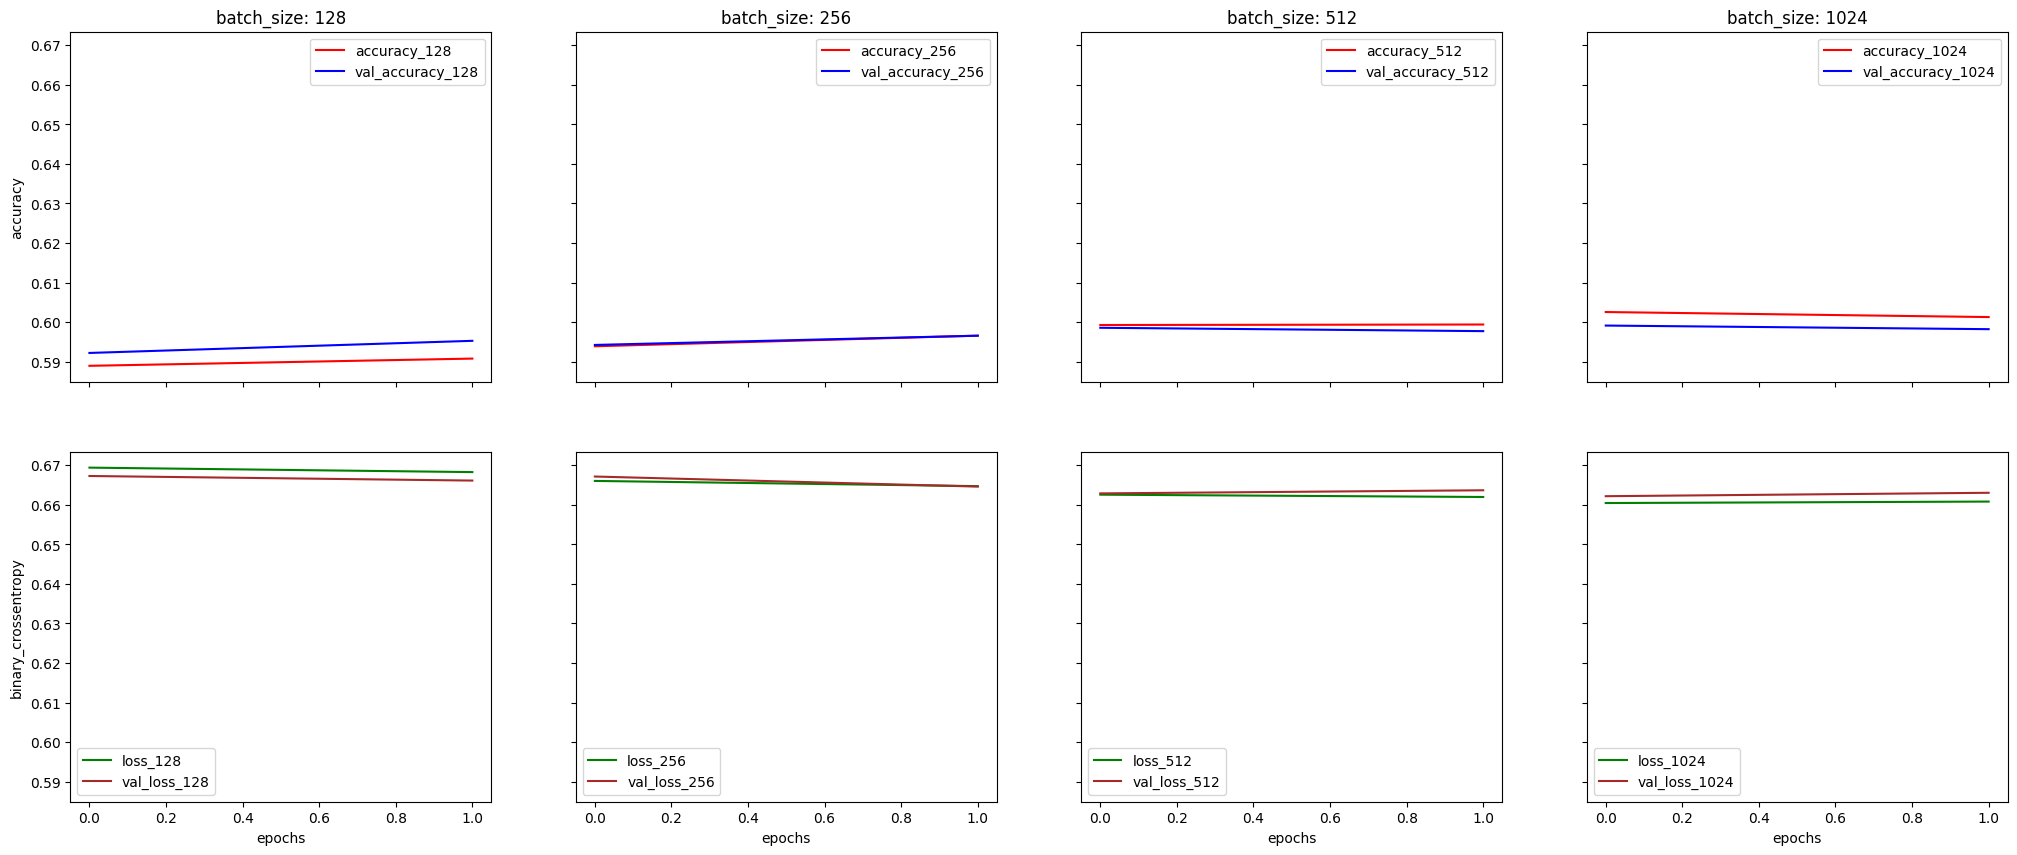

In [ ]:
fig, ax = plt.subplots(2, len(batch_size_list), sharex=True, sharey=True, figsize=(25, 10))

ax[0, 0].set_ylabel("accuracy")
ax[1, 0].set_ylabel("binary_crossentropy")

for i, batch_size in enumerate(batch_size_list):
	ax[0, i].plot(trained_models['batch_size_' + str(batch_size)]['accuracy'], color='red', label='accuracy_' + str(batch_size))
	ax[1, i].plot(trained_models['batch_size_' + str(batch_size)]['loss'], color='green', label='loss_' + str(batch_size))
	ax[0, i].plot(trained_models['batch_size_' + str(batch_size)]['val_accuracy'], color='blue', label='val_accuracy_' + str(batch_size))
	ax[1, i].plot(trained_models['batch_size_' + str(batch_size)]['val_loss'], color='brown', label='val_loss_' + str(batch_size))
	ax[1, i].set_xlabel("epochs")
	ax[0, i].set_title("batch_size: " + str(batch_size))
	ax[0, i].legend()
	ax[1, i].legend()


plt.show()

In [23]:
# Guardar el Modelo
# model_1.save('models/cnn_model_2.h5')

In [ ]:
evaluate_test = model_1.evaluate(test.drop(['winner'], axis=1), np.asarray(test['winner']).astype(np.float32), batch_size=256)
# loss_test = evaluate_test[0]
# accuracy = evaluate_test[1]
# mse = evaluate_test[2]
false_negatives_test = evaluate_test[3]
false_positives_test = evaluate_test[4]
true_negatives_test = evaluate_test[5]
true_positives_test = evaluate_test[6]

1518/1518 [==============================] - 10s 6ms/step - loss: 0.8776 - accuracy: 0.5870 - mse: 0.2604 - false_negatives: 71264.0000 - false_positives: 89150.0000 - true_negatives: 93303.0000 - true_positives: 134717.0000


In [14]:
# test['prediction'] = model_1.predict(test.drop(['winner'], axis=1))
# test['prediction_result'] = test['prediction'].apply(lambda x: True if x > 0.5 else False).astype(bool)

# def get_metrics(test):
# 	true_positives = test[(test['winner'] == True) & (test['winner'] == test['prediction_result'])].shape[0]
# 	true_negatives = test[(test['winner'] == False) & (test['winner'] == test['prediction_result'])].shape[0]
# 	false_positives = test[(test['winner'] == False) & (test['winner'] != test['prediction_result'])].shape[0]
# 	false_negatives = test[(test['winner'] == True) & (test['winner'] != test['prediction_result'])].shape[0]
# 	return true_positives, true_negatives, false_positives, false_negatives

# true_positives_test, true_negatives_test, false_positives_test, false_negatives_test = get_metrics(test)

In [ ]:
false_positives_train = trained_models["sequential_2"]['false_positives'][-1]
false_negatives_train = trained_models["sequential_2"]['false_negatives'][-1]
true_positives_train = trained_models["sequential_2"]['true_positives'][-1]
true_negatives_train = trained_models["sequential_2"]['true_negatives'][-1]
f1_score_train = 2 * (true_positives_train / (2 * true_positives_train + false_positives_train + false_negatives_train))
accuracy_train = (true_positives_train + true_negatives_train) / (true_positives_train + true_negatives_train + false_positives_train + false_negatives_train)

print('F1 Score Train: ' + str(f1_score_train))
print('Accuracy Train: ' + str(accuracy_train))

F1 Score Train: 0.7104388227768913
Accuracy Train: 0.6818366125388581


In [ ]:
f1_score_test = 2 * (true_positives_test / (2 * true_positives_test + false_positives_test + false_negatives_test))
accuracy_test = (true_positives_test + true_negatives_test) / (true_positives_test + true_negatives_test + false_positives_test + false_negatives_test)

print('F1 Score Test: ' + str(f1_score_test))
print('Accuracy Test: ' + str(accuracy_test))

F1 Score Test: 0.6268122685228267
Accuracy Test: 0.5870237929738386
